In [2]:
import os
from pathlib import Path
import numpy as np
import cv2
%pylab inline

import lib.orientation as orient
from lib.camera import img_from_device, denormalize, view_frame_from_device_frame

Populating the interactive namespace from numpy and matplotlib


In [78]:
from utils.paths import get_local_path

## Using the comma library to display the driven path 

In [45]:
example_segment = Path("/media/watouser/Seagate_Backup/datasets/comma2k19/Chunk_3/99c94dc769b5d96e|2018-05-05--11-09-01/12")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Driven path projected onto first image')

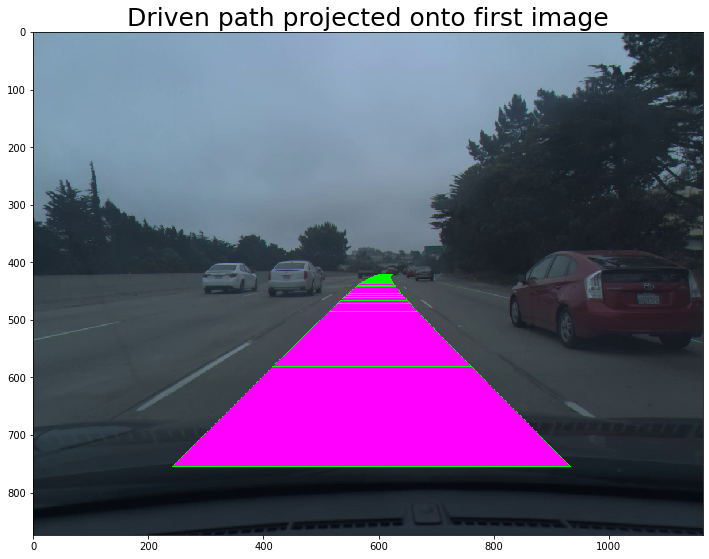

In [46]:
# We can project the path driven onto the first image
frame_times = np.load(example_segment / 'global_pose/frame_times')
frame_positions = np.load(example_segment / 'global_pose/frame_positions')
frame_orientations = np.load(example_segment / 'global_pose/frame_orientations')

# first we convert the frame_positions to the frame
# defined by the pose of the first frame
ecef_from_local = orient.rot_from_quat(frame_orientations[0])
local_from_ecef = ecef_from_local.T
frame_positions_local = np.einsum('ij,kj->ki', local_from_ecef, frame_positions - frame_positions[0])

def draw_path(device_path, img, width=1, height=1, fill_color=(128,0,255), line_color=(0,255,0)):
    device_path_l = device_path + np.array([0, 0, height])                                                                    
    device_path_r = device_path + np.array([0, 0, height])                                                                    
    device_path_l[:,1] -= width                                                                                               
    device_path_r[:,1] += width

    img_points_norm_l = img_from_device(device_path_l)
    img_points_norm_r = img_from_device(device_path_r)
    img_pts_l = denormalize(img_points_norm_l)
    img_pts_r = denormalize(img_points_norm_r)

    # filter out things rejected along the way
    valid = np.logical_and(np.isfinite(img_pts_l).all(axis=1), np.isfinite(img_pts_r).all(axis=1))
    img_pts_l = img_pts_l[valid].astype(int)
    img_pts_r = img_pts_r[valid].astype(int)

    for i in range(1, len(img_pts_l)):
        u1,v1,u2,v2 = np.append(img_pts_l[i-1], img_pts_r[i-1])
        u3,v3,u4,v4 = np.append(img_pts_l[i], img_pts_r[i])
        pts = np.array([[u1,v1],[u2,v2],[u4,v4],[u3,v3]], np.int32).reshape((-1,1,2))
        cv2.fillPoly(img,[pts],fill_color)
        cv2.polylines(img,[pts],True,line_color)

img = imread(str(example_segment / 'preview.png'))
draw_path(frame_positions_local[1:61], img) # show next 3 seconds (60 frames)
figsize(12,12);
imshow(img)
title('Driven path projected onto first image', fontsize=25)

In [5]:
frame_positions_local[1:61] # (n, 3) where cols are x,y,z
# These are the coordinates of the path in 3D space relative to the reference frame
# x is the axis along the length of the car
# y is the axis along the width of the car
# z is the axis along the height of the car

array([[ 1.46928445e+00,  7.03539996e-03, -4.64520571e-02],
       [ 2.93795098e+00,  1.06647938e-02, -9.62151437e-02],
       [ 4.40643795e+00,  1.09802726e-02, -1.49351551e-01],
       [ 5.87498830e+00,  8.60447011e-03, -2.06173580e-01],
       [ 7.34276326e+00,  4.14701238e-03, -2.66057051e-01],
       [ 8.81157828e+00, -2.36103213e-03, -3.27622714e-01],
       [ 1.02803807e+01, -1.09475148e-02, -3.89124884e-01],
       [ 1.17503589e+01, -2.19985383e-02, -4.49268356e-01],
       [ 1.32202592e+01, -3.57208856e-02, -5.07269802e-01],
       [ 1.46908642e+01, -5.22066404e-02, -5.62539533e-01],
       [ 1.61604011e+01, -7.21800768e-02, -6.15705728e-01],
       [ 1.76297136e+01, -9.57876308e-02, -6.67588996e-01],
       [ 1.90991114e+01, -1.23569987e-01, -7.18820441e-01],
       [ 2.05699869e+01, -1.55008048e-01, -7.69603609e-01],
       [ 2.20399896e+01, -1.89413968e-01, -8.19714044e-01],
       [ 2.35099048e+01, -2.26627575e-01, -8.68761570e-01],
       [ 2.49801920e+01, -2.66732132e-01

## Finding the fps of the data stream

In [6]:
frame_times.shape

(1201,)

In [7]:
frame_times

array([1126.495425, 1126.545434, 1126.595427, ..., 1186.394608,
       1186.444614, 1186.494585])

In [8]:
frame_len = (frame_times[-1] - frame_times[0])/frame_times.shape[0]
print(frame_len) # Each frame is ~0.05 seconds apart (20 fps)
n = 3
print(n/frame_len) # Number of frames needed for n seconds

0.04995766860949196
60.05084071177012


## Loading in the processed dataset and getting the driven path

In [9]:
dataset_path = Path("/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset")

In [10]:
segment_path = dataset_path / '2018-07-06--11-17-49'
for file in segment_path.glob('*'):
    print(file)

/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-06--11-17-49/CAN_angles.npy
/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-06--11-17-49/CAN_speeds.npy
/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-06--11-17-49/frame_orientations.npy
/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-06--11-17-49/frame_positions.npy
/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-06--11-17-49/frame_times.npy
/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-06--11-17-49/frame_velocities.npy
/media/watouser/Seagate_Backup/datasets/comma2k19/processed_dataset/2018-07-06--11-17-49/images


In [70]:
# Load in data for this segment
frame_times = np.load(segment_path / 'frame_times.npy')
frame_positions = np.load(segment_path / 'frame_positions.npy')
frame_orientations = np.load(segment_path / 'frame_orientations.npy')
frame_velocities = np.load(segment_path / 'frame_velocities.npy')
frame_speed = np.linalg.norm(frame_velocities, axis=1) # predict this during training

In [71]:
def get_local_path(positions, orientations, reference_idx):
    # Define the segment frame positions referenced at a desired frame
    ecef_from_local = orient.rot_from_quat(orientations[reference_idx])
    local_from_ecef = ecef_from_local.T
    positions_local = np.einsum('ij,kj->ki', local_from_ecef, positions - positions[reference_idx])
    return positions_local

Text(0.5, 1.0, 'Frame 1900')

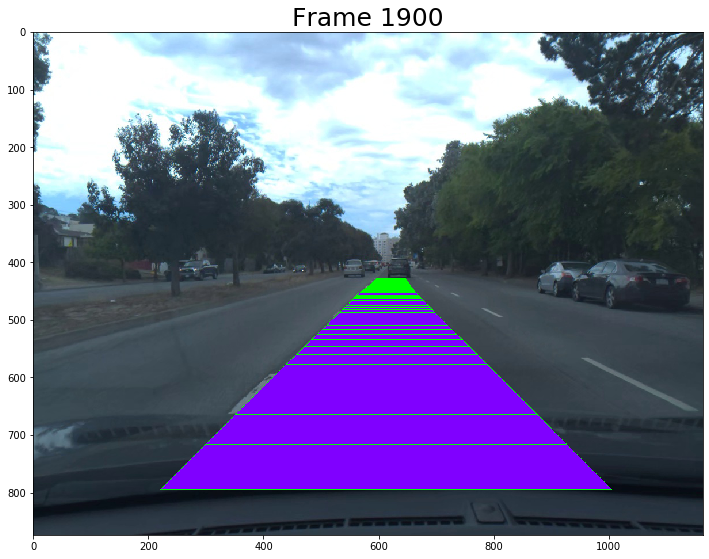

In [77]:
index = 1900
local_path = get_local_path(frame_positions, frame_orientations, index)
img_name = str(index).zfill(6) + '.jpg'
image = imread(str(segment_path / 'images' / img_name))
draw_path(local_path[index:index+60], image) # show 3 seconds
figsize(12,12);
imshow(image)
title(f"Frame {index}", fontsize=25)